### Environment Setup

In [4]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [5]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from numpy.linalg import inv
from scipy import interpolate

from scipy.optimize import minimize
from sklearn.metrics import r2_score

%matplotlib inline

### Getting File

In [6]:
dandiset_id = "000021"
dandi_filepath = "sub-717038285/sub-717038285_ses-732592105.nwb"
# dandiset_id = "000563"
# dandi_filepath = "sub-688546/sub-688546_ses-1295360519.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [7]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.58.2) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Units

In [8]:
# select electrodes
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# function aligns location information from electrodes table with channel id from the units table
def get_unit_location(row):
    return channel_probes[int(row.peak_channel_id)]

In [9]:
nwb.units.colnames

('velocity_below',
 'amplitude_cutoff',
 'repolarization_slope',
 'snr',
 'firing_rate',
 'waveform_duration',
 'presence_ratio',
 'isi_violations',
 'cumulative_drift',
 'spread',
 'max_drift',
 'PT_ratio',
 'nn_hit_rate',
 'quality',
 'recovery_slope',
 'velocity_above',
 'isolation_distance',
 'l_ratio',
 'peak_channel_id',
 'd_prime',
 'cluster_id',
 'amplitude',
 'waveform_halfwidth',
 'local_index',
 'silhouette_score',
 'nn_miss_rate',
 'spike_times',
 'spike_amplitudes',
 'waveform_mean')

In [10]:
units_spike_times = []
for row in nwb.units:
    if get_unit_location(row) == "VISp" and row.quality.item() == "good":
        units_spike_times.append(row.spike_times.item())

print(len(units_spike_times))

244


### Stimulus

In [11]:
nwb.intervals.keys()

dict_keys(['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations'])

In [12]:
flashes_table = nwb.intervals["flashes_presentations"]
flashes_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,1282.632614,1282.882832,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3647, 1, timestamps pynwb.base.TimeSeries at..."
1,1284.634334,1284.884540,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3648, 1, timestamps pynwb.base.TimeSeries at..."
2,1286.636014,1286.886217,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3649, 1, timestamps pynwb.base.TimeSeries at..."
3,1288.637634,1288.887855,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3650, 1, timestamps pynwb.base.TimeSeries at..."
4,1290.639354,1290.889562,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3651, 1, timestamps pynwb.base.TimeSeries at..."
5,1292.641034,1292.891240,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3652, 1, timestamps pynwb.base.TimeSeries at..."
6,1294.642714,1294.892917,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3653, 1, timestamps pynwb.base.TimeSeries at..."
7,1296.644364,1296.894572,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3654, 1, timestamps pynwb.base.TimeSeries at..."
8,1298.646074,1298.896272,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3655, 1, timestamps pynwb.base.TimeSeries at..."


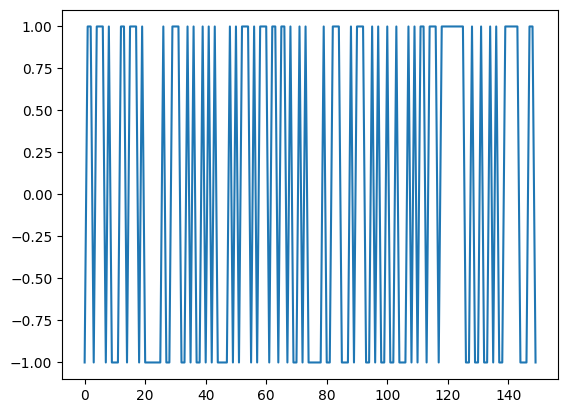

In [13]:
plt.plot([float(color) for color in flashes_table.color])

In [14]:
len(set(flashes_table.color))

2

### Running

In [15]:
running_data = nwb.acquisition["raw_running_wheel_rotation"].data
running_timestamps = nwb.acquisition["raw_running_wheel_rotation"].timestamps

### Aligning

In [16]:
first_run_time = running_timestamps[0]
last_run_time = running_timestamps[-1]
first_stim_time = flashes_table.start_time[0]
last_stim_time = flashes_table.stop_time[-1]
first_time = max(first_stim_time, first_run_time)
last_time = min(last_stim_time, last_run_time)
first_time = first_stim_time
last_time = last_stim_time

# run_start_idx, run_end_idx = np.searchsorted(running_timestamps, [first_time, last_time])
# stim_start_idx, stim_end_idx = np.searchsorted(flashes_table.start_time, [first_time, last_time])

# running_data_slice = running_data[run_start_idx:run_end_idx]
# running_timestamps_slice = running_timestamps[run_start_idx:run_end_idx]

print("first time:", first_time, "last time:", last_time)

first time: 1282.6326142945445 last time: 1581.1321471083802


In [17]:
# bin_res = np.mean(np.diff(flashes_table.start_time)) / 3
# interp_hz = 1/bin_res
interp_hz = 100

In [18]:
time_axis = np.arange(first_time, last_time, step=(1/interp_hz))
interp_flashes = np.zeros(len(time_axis))

for index, individual_time in enumerate(time_axis):
    for i in range(len(flashes_table)):
        flash_start, flash_stop = flashes_table.start_time[i], flashes_table.stop_time[i]
        if individual_time >= flash_start and individual_time < flash_stop:
            if flashes_table.color[i] == "1.0":
                interp_flashes[index] = 1.0

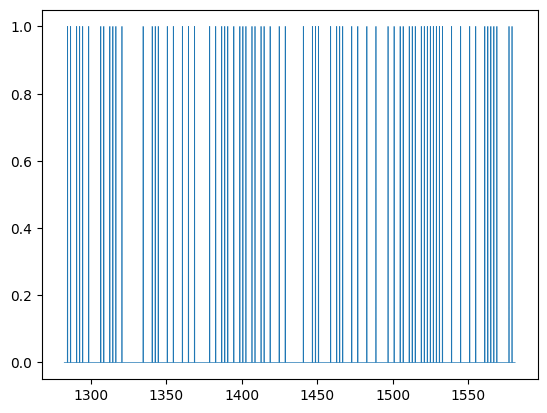

In [19]:
plt.plot(time_axis, interp_flashes, lw=0.5)

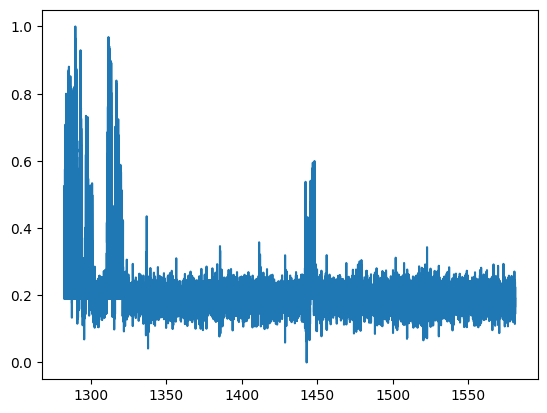

In [20]:
f = interpolate.interp1d(running_timestamps, running_data, axis=0, kind="nearest", fill_value="extrapolate")
interp_running = f(time_axis)

norm_running = (interp_running-np.min(interp_running)) / (np.max(interp_running)-np.min(interp_running))
plt.plot(time_axis, norm_running)

### Combining

In [21]:
# coefficient to add running to stimulus
mod_coef = 0.25

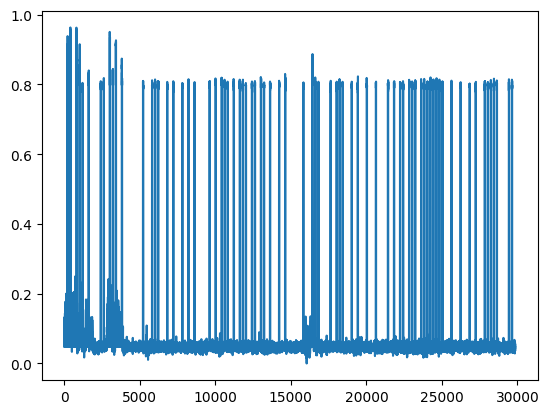

In [22]:
# exog = interp_flashes * norm_running
exog = (1-mod_coef)*interp_flashes + mod_coef*norm_running
# exog = interp_flashes
plt.plot(exog)

In [23]:
print(first_stim_time, last_stim_time)
print(interp_hz)
print(len(exog))
print(len(time_axis))
print(len(units_spike_times[0]))

1282.6326142945445 1581.1321471083802
100
29850
29850
7825


### Fake Data

0.0 5.0
500


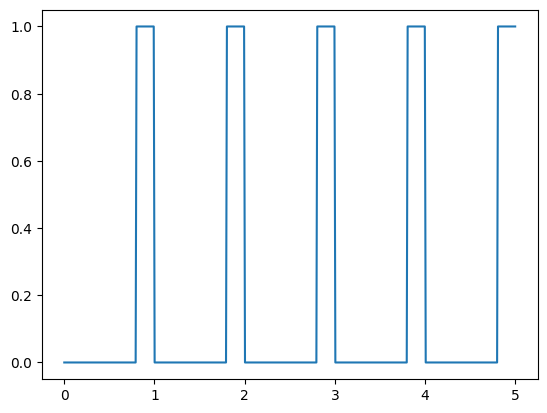

In [24]:
def make_flashes(time_start, time_end, pattern, n_repeats):
    flashes = np.tile(pattern, n_repeats)
    time_axis = np.linspace(time_start, time_end, len(flashes))
    return time_axis, flashes

time_axis, exog = make_flashes(0, 5, [0]*80 + [1]*20, 5)
print(time_axis[0], time_axis[-1])
print(len(exog))
plt.plot(time_axis, exog)

In [25]:
def make_spikes(stim, baseline_rate, coeff):
    weighted_stim = (stim*coeff) + baseline_rate
    exp_stim = np.exp(weighted_stim)
    spikes = np.random.poisson(exp_stim)
    return spikes[1:]

spikes_binned = make_spikes(exog, 0.05, 0.7)
# plt.plot(time_axis[:500], spikes_binned[:500])
print(len(spikes_binned))

499


### Design Matrix

In [26]:
# length of filter (# bins)
ntfilt = 1

In [27]:
def get_design_mat(ntfilt, stim, num_time_bins):
    padded_stim = np.hstack((np.zeros((ntfilt-1)), stim)) # pad early bins of stimulus with zero
    design_mat = np.zeros((num_time_bins,ntfilt))
    for j in np.arange(num_time_bins):
        design_mat[j] = padded_stim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat

In [28]:
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)

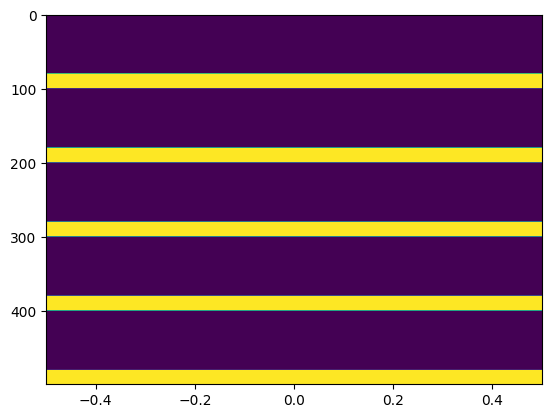

In [29]:
plt.imshow(design_mat, aspect="auto")

In [30]:
design_mat.shape

(499, 1)

### Class

In [31]:
def neglogli_poissGLM(thetas, xx, yy, dt_bin, vals_to_return=3):
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas # filter output
    # vv = xx @ thetas  # filter output
    rr = np.exp(vv) * dt_bin  # conditional intensity (per bin)

    if len(np.where(np.isnan(rr))[0]) > 0:
        print('at GLM filter output')

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy;  # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term
    neglogli = Trm1 + Trm0

    # ---------  Compute Gradient -----------------
    dL1 = -xx.T @ yy  # spiking term (the spike-triggered average)
    dL0 = xx.T @ rr  # non-spiking term
    dL = dL1 + dL0

    if len(np.where(np.isnan(dL0))[0]) > 0:
        print('At gradient')

    # ---------  Compute Hessian -------------------
    H = xx.T @ (xx * np.transpose([rr]))  # non-spiking term

    if len(np.where(np.isnan(H))[0]) > 0:
        print('At hessian')

    if vals_to_return == 3:
        return neglogli, dL, H
    else:
        return [neglogli, dL, H][vals_to_return]


In [32]:
def neglogposterior(thetas, neglogli_fun, Cinv, vals_to_return=3):
    neglogpost, grad, H = neglogli_fun(thetas)
    neglogpost = neglogpost + .5 * thetas.T @ Cinv @ thetas
    grad = grad + Cinv @ thetas
    H = H + Cinv

    if vals_to_return == 3:
        return neglogpost, grad, H
    else:
        return [neglogpost, grad, H][vals_to_return]

In [33]:
def fit(X, y, bin_sz=1, lam=8):
    w0 = (X.T @ y) / np.sum(y)

    Imat = np.identity(X.shape[1])  # identity matrix of size of filter + const
    Imat[0, 0] = 0

    neglogli_func = lambda prs: neglogli_poissGLM(prs, X, y, bin_sz)

    Cinv = lam * Imat  # set inverse prior covariance
    loss_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=0)
    grad_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=1)
    hess_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=2)
    optimizer = minimize(fun=loss_post_func, x0=w0, method='trust-ncg', jac=grad_post_func,
                            hess=hess_post_func,
                            tol=1e-6, options={'disp': False, 'maxiter': 100})
    return optimizer.x

### Generating Filters

In [34]:
# filters = []
# for i, spike_times in enumerate(units_spike_times):
#     spike_times = units_spike_times[i]
#     these_spikes_binned, _ = np.histogram(spike_times, time_axis)
#     try:
#         res = fit(design_mat_offset, these_spikes_binned, 100, lam=2**10)
#         const, filt = res[0], res[1:]
#         filters.append(filt)
#         print(i)
#     except:
#         filters.append([])

In [35]:
# n_cols=10

# n_rows = ceil(len(filters)/n_cols)
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, n_rows))
# if len(axes.shape) == 1:
#     axes = axes.reshape((1, axes.shape[0]))

# for i in range(len(filters)):
#     f = filters[i]
#     row = i // n_cols
#     col = i % n_cols
#     axes[row][col].plot(f)
#     axes[row][col].set_ylabel(i)

# fig.tight_layout()
# plt.show()

In [36]:
# unit_idx = 134
# spike_times = units_spike_times[unit_idx]
# print(spike_times)

In [37]:
# num_spikes = len(time_axis)
# # spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
# spikes_binned,_ = np.histogram(spike_times, time_axis)

### Binning spikes

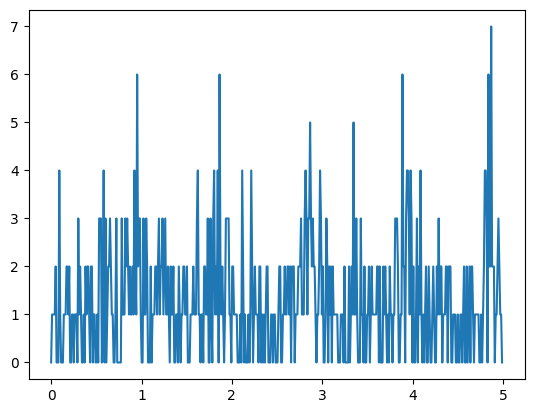

In [374]:
plt.plot(time_axis[:-1], spikes_binned)

### Fitting With Regularization

In [ ]:
n_repeats = []
filters = []
constants = []

for i in range(18):
    for j in range(10):
        print("i:",i,"j:",j)
        repeats = 2**i
        time_axis, exog = make_flashes(0, repeats, [0]*80 + [1]*20, repeats)
        spikes_binned = make_spikes(exog, 0.05, 0.7)
        
        ntfilt = 1
        num_time_bins = len(exog)-1
        design_mat = get_design_mat(ntfilt, exog, num_time_bins)
        design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

        res = fit(design_mat_offset, spikes_binned, lam=2**i)
        constant, filter = res[0], res[1:]
        n_repeats.append(i)
        filters.append(filter)
        constants.append(constant)

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Length 1 filter as input data length varies")
ax.set_xlabel("# repeats of synthesized flashes")
ax.set_ylabel("filter value")
ax.scatter(n_repeats, filters)

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_title("GLM Constant as input data length varies")
ax.set_xlabel("# repeats of synthesized flashes")
ax.set_ylabel("constant value")
ax.scatter(n_repeats, constants)

### Predict Activity

In [39]:
def predict(X, weights, constant, bin_sz=1):
    y = np.exp(X @ weights + constant) * bin_sz
    return y

def predict_spikes(X, weights, constant, bin_sz=1):
    rate = predict(X, weights, constant, bin_sz)
    spks = np.random.poisson(np.matrix.transpose(rate))
    return spks

-0.7613560226173106
0.0635145595677565
1.2657554429257383
1.264518774197957


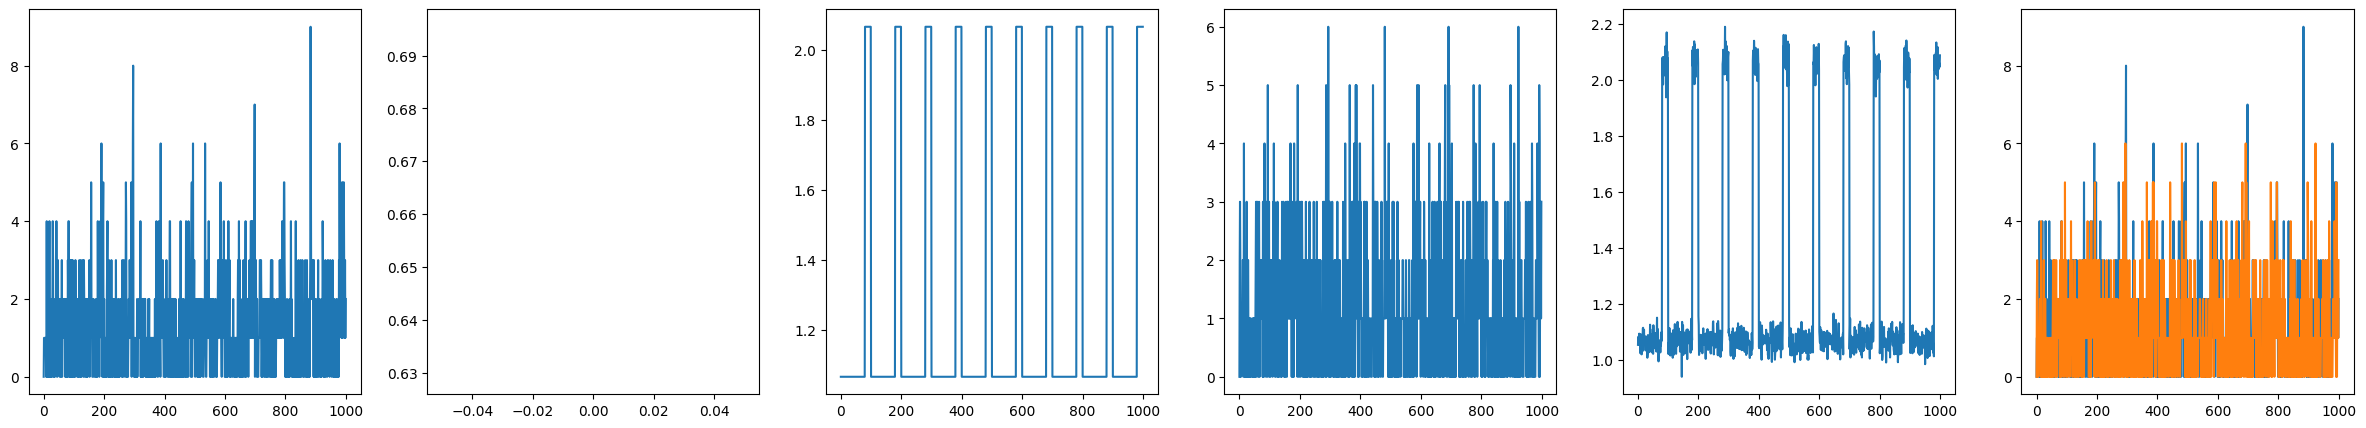

In [41]:
fig, axes = plt.subplots(1,6, figsize=(30,5))

### predict
predictions = []
for j in range(1000):
    predictions.append(predict_spikes(design_mat, filter, constant))

prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
avg_predicted = np.mean(predictions, axis=0)

axes[0].plot(spikes_binned[0:1000])
axes[1].plot(filter)
axes[2].plot(prob_predicted[0:1000])
axes[3].plot(spikes_predicted[0:1000])
axes[4].plot(avg_predicted[0:1000])
axes[5].plot(spikes_binned[0:1000])
axes[5].plot(spikes_predicted[0:1000])

print(r2_score(spikes_binned, spikes_predicted))
print(constant)
print(np.sum(spikes_binned) / len(spikes_binned))
print(np.sum(spikes_predicted) / len(spikes_predicted))

plt.show()

In [42]:
mse2 = np.mean((spikes_binned-spikes_predicted)**2)  # mean squared error, with offset
rss = np.mean((spikes_binned-np.mean(spikes_binned))**2)    # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, w/ offset: {:.2f}'.format(1-mse2/rss))

Training perf (R^2): lin-gauss GLM, w/ offset: -0.76


0 -0.9818953834197548
1 -0.9843857092102921
2 -0.8874315230985894
3 -0.9780192863134516
4 -1.006681809091035
5 -1.036742001088958
6 -0.9956530915420538
7 -0.886552482929728
8 -0.9261270797273995
9 -0.9874709071839123
10 -0.9442364696130878
11 -0.915719651616411
12 -1.0228756171864433
13 -0.968798140239399
14 -0.8848101727044546
15 -0.9370310961194934
16 -0.9184605092981193
17 -1.0895912027193777
18 -1.0288368900489124
19 -1.049342387820722


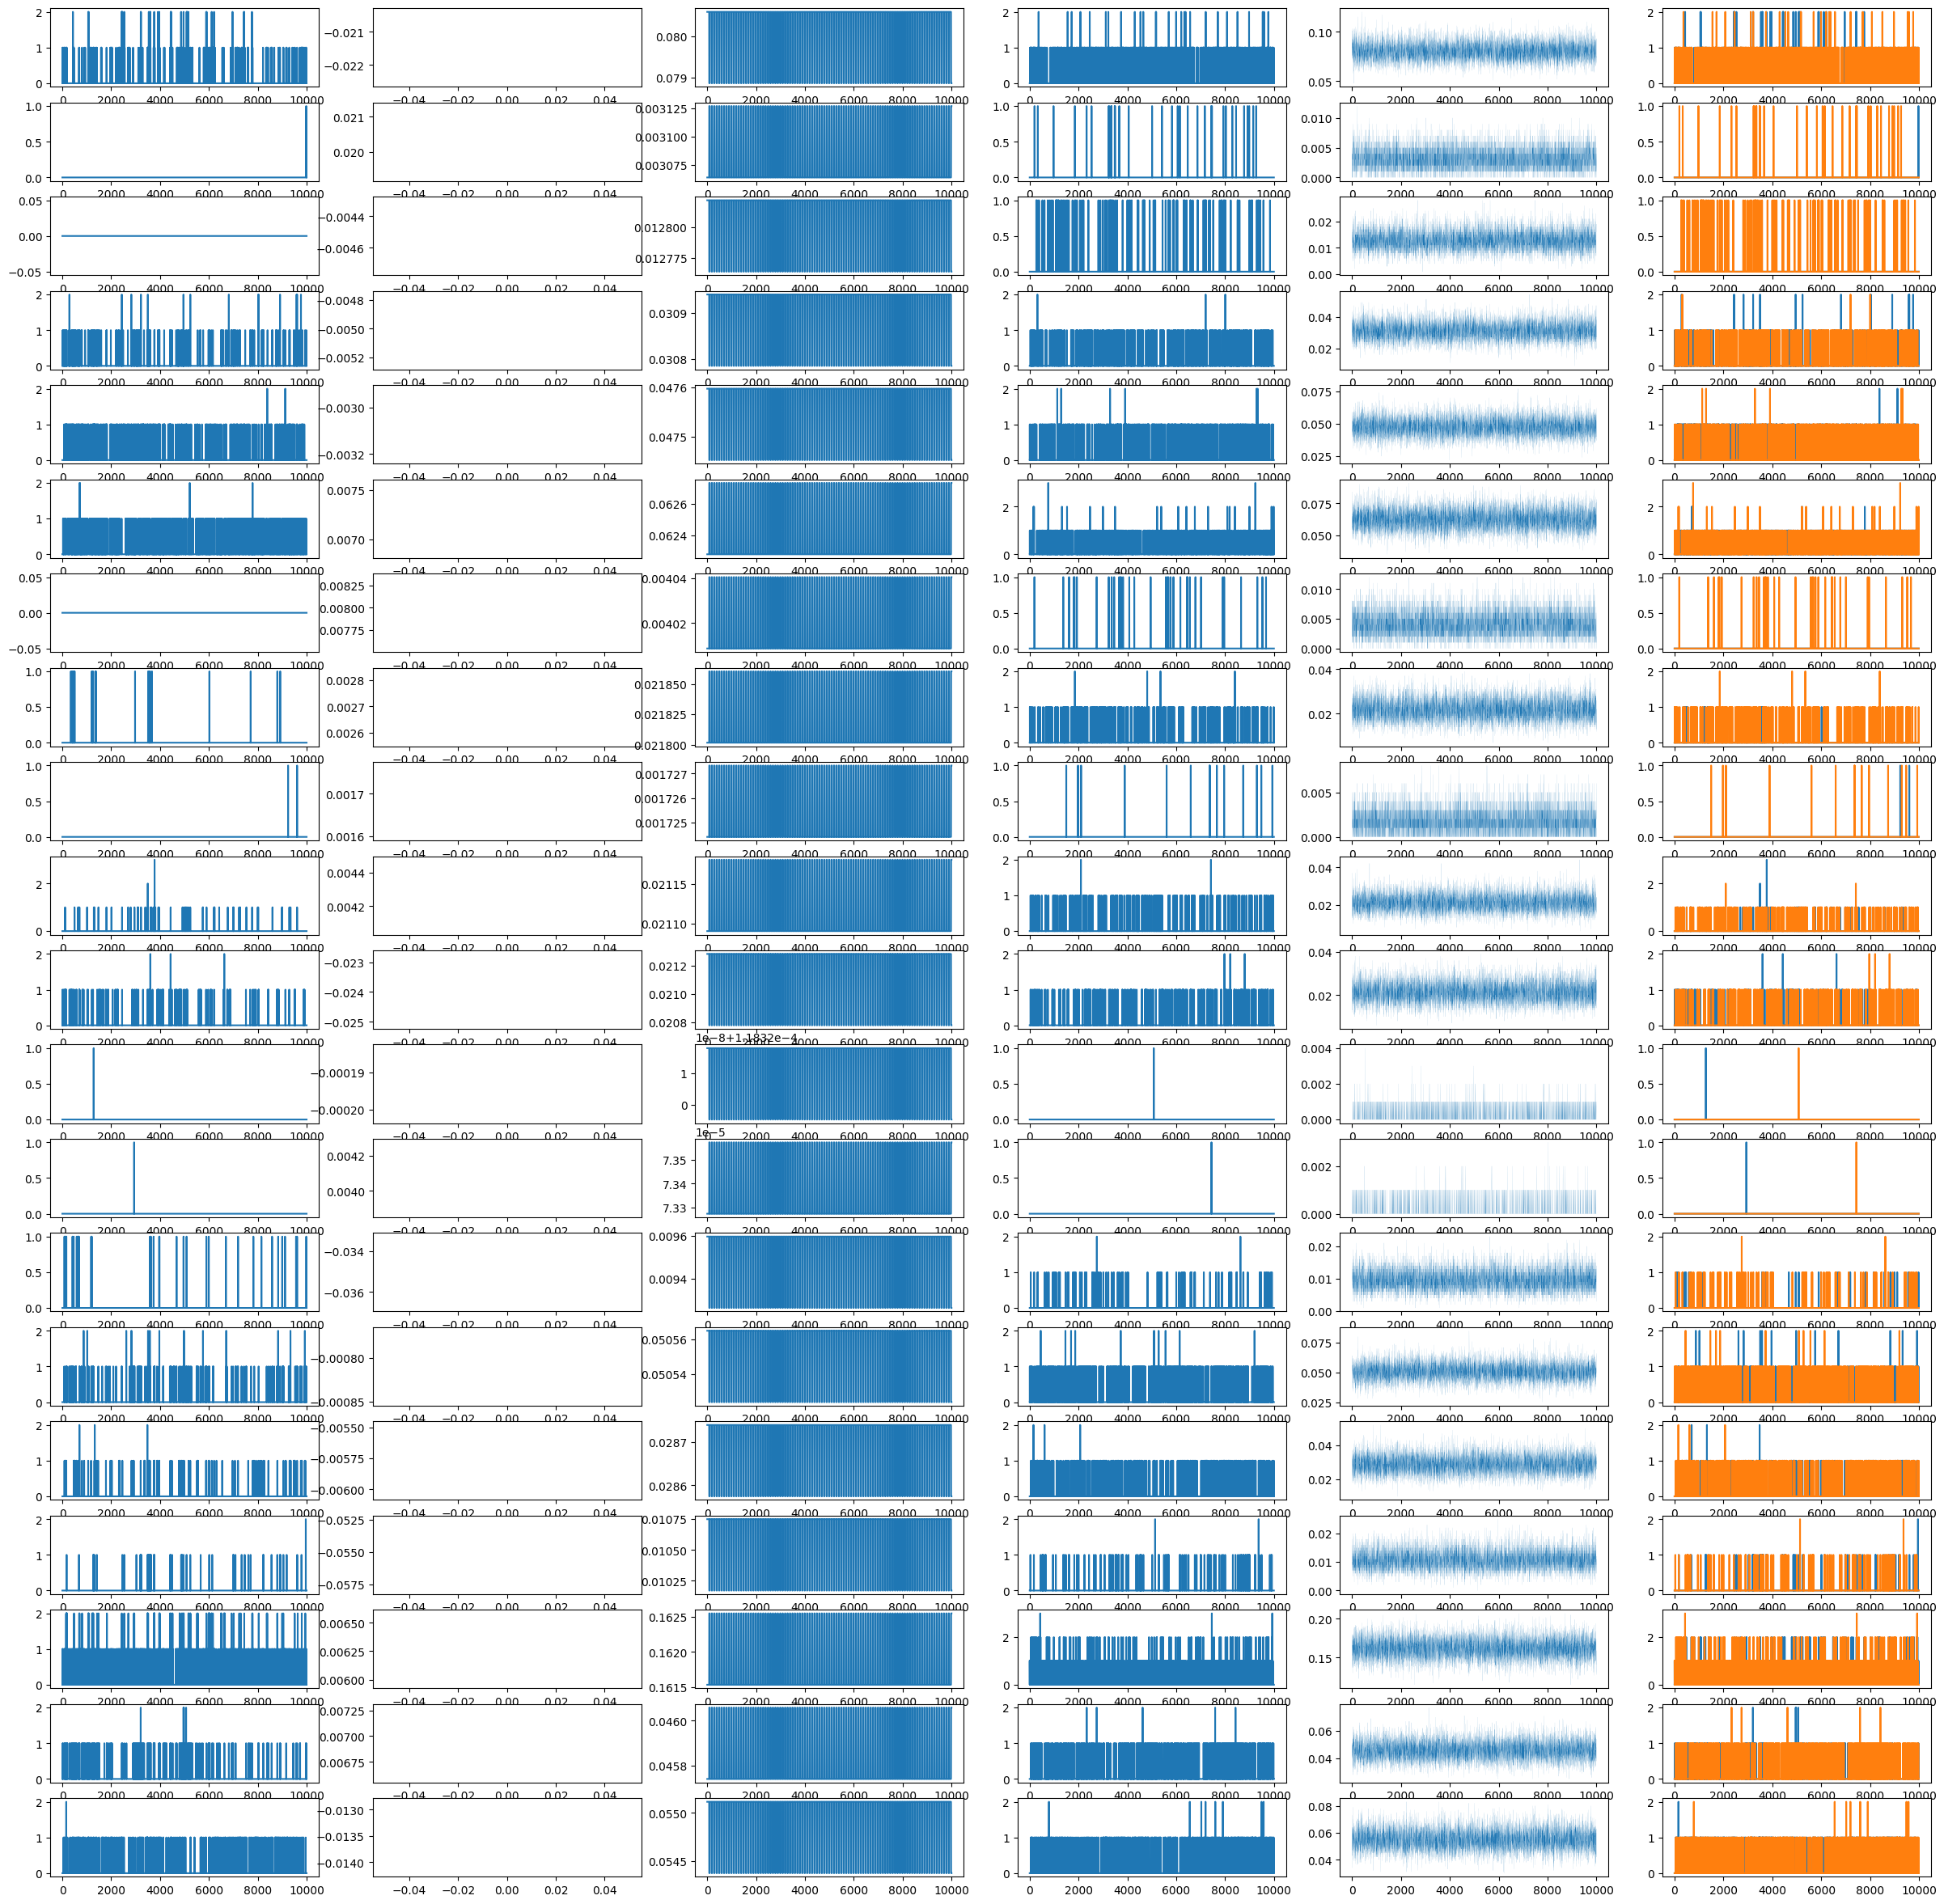

In [43]:
# %matplotlib

fig, axes = plt.subplots(20,6, figsize=(30,30))
for i in range(20):
    t = 120
    unit_idx = 120+i
    spike_times = units_spike_times[unit_idx]

    num_spikes = len(time_axis)
    # spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
    spikes_binned,_ = np.histogram(spike_times, time_axis)

    ### fit
    design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones
    res = fit(design_mat_offset, spikes_binned, lam=2**10)
    constant, filter = res[0], res[1:]

    ### predict
    predictions = []
    for j in range(1000):
        predictions.append(predict_spikes(design_mat, filter, constant))

    prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
    spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
    avg_predicted = np.mean(predictions, axis=0)

    axes[i][0].plot(spikes_binned[20000:30000])
    axes[i][1].plot(filter)
    axes[i][2].plot(prob_predicted[20000:30000])
    axes[i][3].plot(spikes_predicted[20000:30000])
    axes[i][4].plot(avg_predicted[20000:30000], lw=0.05)
    axes[i][5].plot(spikes_binned[20000:30000])
    axes[i][5].plot(spikes_predicted[20000:30000])

    print(i, r2_score(spikes_binned, spikes_predicted))

plt.show()

In [44]:
plt.show()

In [45]:
print(np.sum(spikes_binned) / len(spikes_binned))
print(np.sum(spikes_predicted) / len(spikes_predicted))

0.05496675827793046
0.05495342492237487
